In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from utils import generate_data
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
plt.rcParams["figure.figsize"] = (12,6)
import warnings
from timeit import default_timer as timer

/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
data = generate_data()

In [3]:
data.x_df.head()
# days since start is z normalized

,intercept,days_since_start,days_since_start_squared,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,seasonality_cos,seasonality_sin
0,1.0,-1.729679,2.228932,0,0,0,0,0,1,0.999852,0.017213
1,1.0,-1.726517,2.216707,0,0,0,0,0,0,0.999407,0.034422
2,1.0,-1.723355,2.204505,1,0,0,0,0,0,0.998667,0.051620
3,1.0,-1.720193,2.192325,0,1,0,0,0,0,0.997630,0.068802
4,1.0,-1.717031,2.180168,0,0,1,0,0,0,0.996298,0.085965


In [4]:
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 6.037352
         Iterations: 8
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 8


In [5]:
gpois_res.params

intercept                   5.256083
days_since_start            0.347004
days_since_start_squared   -0.156006
day_of_week_1               0.211024
day_of_week_2               0.208520
day_of_week_3               0.224167
day_of_week_4               0.209369
day_of_week_5               0.265378
day_of_week_6               0.018856
seasonality_cos             0.155045
seasonality_sin            -0.071259
alpha                       7.277575
dtype: float64

In [6]:
print(gpois_res.summary2())

                       Results: GeneralizedPoisson
Model:                 GeneralizedPoisson  Pseudo R-squared:  0.049      
Dependent Variable:    y                   AIC:               13245.8008 
Date:                  2022-04-04 22:59    BIC:               13305.7830 
No. Observations:      1095                Log-Likelihood:    -6610.9    
Df Model:              10                  LL-Null:           -6953.6    
Df Residuals:          1084                LLR p-value:       8.6730e-141
Converged:             1.0000              Scale:             1.0000     
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
intercept                 5.2561   0.0392 134.1093 0.0000  5.1793  5.3329
days_since_start          0.3470   0.0152  22.8429 0.0000  0.3172  0.3768
days_since_start_squared -0.1560   0.0142 -10.9845 0.0000 -0.

In [7]:
# Marginal effects
me = gpois_res.get_margeff(method='dydx')
me.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 GeneralizedPoisson Marginal Effects 
=====================================
Dep. Variable:                      y
Method:                          dydx
At:                           overall
============================================================================================
                              dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
days_since_start            84.5937      3.943     21.451      0.000      76.865      92.323
days_since_start_squared   -38.0315      3.516    -10.818      0.000     -44.922     -31.141
day_of_week_1               51.4440     12.578      4.090      0.000      26.791      76.097
day_of_week_2               50.8335     12.604      4.033      0.000      26.130      75.537
day_of_week_3               54.6480     12.597      4.338      0.000      29.959      79.337
day_of_week_4               51.0405     12.608      4.048      0.000      26.330      75.751
day_of_week_5               64.6946     12.466      5.190      0.000      40.262      89.128
day_of_week_6                4.5969     12.900      0.356      0.722     -20.686      29.880
seasonality_cos             37.7972      4.770      7.925      0.000      28.449      47.145
seasonality_sin            -17.3716      4.787     -3.629      0.000     -26.754      -7.989
============================================================================================
"""

## Extend Generic Likelihood Model

In [8]:
def _ll_latentnorm(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))
    z_bar = (np.log1p(y) - mu) / sigma 
    z_underbar = (np.log(y) - mu) / sigma
    ll = stats.norm.logcdf(z_underbar) + np.log(np.exp(stats.norm.logcdf(z_bar) - stats.norm.logcdf(z_underbar)) - 1.)
    return ll

def _get_kappa(z_bar, z_underbar, q):
    # Log denominator
    log_den = stats.norm.logcdf(z_underbar) + np.log(np.exp(stats.norm.logcdf(z_bar) - stats.norm.logcdf(z_underbar)) - 1.)

    # Witchcraft to get the numerator
    z_bar_pos = ((z_bar)**q) > 0
    z_underbar_pos = ((z_underbar)**q) > 0
    both_pos = z_bar_pos & z_underbar_pos
    both_neg = (~z_bar_pos) & (~z_underbar_pos)
    sign_switch = z_bar_pos & (~z_underbar_pos)
    log_mod_bar = q * np.log(np.abs(z_bar)) + stats.norm.logpdf(z_bar)
    log_mod_underbar = q * np.log(np.abs(z_underbar)) + stats.norm.logpdf(z_underbar)
    bar_mod_larger = log_mod_bar > log_mod_underbar
    keep_order = sign_switch | (both_pos & bar_mod_larger) | (both_neg & (~bar_mod_larger))
    sign = (-1)**(~keep_order)
    log_mod_b = keep_order * log_mod_bar + (~keep_order) * log_mod_underbar
    log_mod_a = (~keep_order) * log_mod_bar + keep_order * log_mod_underbar
    mod_b_greater = log_mod_b > log_mod_a
    log_mod_c = (~mod_b_greater) * log_mod_b + mod_b_greater * log_mod_a
    log_mod_d = mod_b_greater * log_mod_b + (~mod_b_greater) * log_mod_a
    const = (-1)**(~sign_switch)
    log_num = log_mod_c + np.log(np.exp(log_mod_d - log_mod_c) + const)

    # Create kappa_q
    kappa_q = sign * np.exp(log_num - log_den)
    return kappa_q

def _gradutils(y, X, beta, alph):
    mu = (np.dot(X, beta)) # Should we exponentiate this??
    sigma = np.exp(np.dot(X, alph))

    z_bar = (np.log1p(y) - mu) / sigma 
    z_underbar = (np.log(y) - mu) / sigma
    
    kappa_0 = _get_kappa(z_bar, z_underbar, 0)
    kappa_1 = _get_kappa(z_bar, z_underbar, 1)
    kappa_2 = _get_kappa(z_bar, z_underbar, 2)
    kappa_3 = _get_kappa(z_bar, z_underbar, 3)
    
    return kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma
    
def _vec_matrix_multiply(a, B):
    return np.apply_along_axis(lambda x: x * a, 0, B)

def _em_gradutils(W, sigma, c, alpha, return_hessian=False):
    sigma_neg_2 = sigma**-2
    grad = W.T @ (sigma_neg_2 * c - 1.) - alpha
    hessian = None
    if return_hessian:
        W_sqrt_k = _vec_matrix_multiply(np.sqrt(c)/sigma, W)
        hessian = -2. * W_sqrt_k.T @ W_sqrt_k
    return grad, hessian

In [9]:
class MyLatentNormal(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(MyLatentNormal, self).__init__(endog, exog, **kwds)
        self.nparams = 22
        
    def nloglikeobs(self, params):
        exog = self.exog
        endog = self.endog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        ll = _ll_latentnorm(endog, exog, beta, alph)
        params_alt = params.copy()
        params_alt[0] = 0.
#         params_alt[11] = 0.
        return -ll - self.penalty*np.sum(params_alt**2)/self.endog.size
    
    def score(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        beta_alt = beta.copy()
        beta_alt[0] = 0
        alph_alt = alph.copy()
#         alph_alt[0] = 0.
        
        grad_beta = -(kappa_0 / sigma) @ X - self.penalty*2 * beta_alt
        grad_alph = -kappa_1 @ X - self.penalty*2 * alph_alt
        
        return np.append(grad_beta, grad_alph)
    
    def hessian(self, params):
        y = self.endog
        X = self.exog
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(y, X, beta, alph)
        
        #xx = np.einsum('ij,ij-> i', X, X) # row-wise dot product?
        k_beta = (kappa_0**2 + kappa_1) / sigma**2
        k_alph = kappa_1 * (kappa_1 - 1) + kappa_3
        k_beta_alph = (kappa_2 + kappa_0*(kappa_1 - 1)) / sigma
        H_beta = np.zeros([11, 11])
        H_alph = np.zeros([11, 11])
        H_beta_alph = np.zeros([11, 11])
                  
        for i in range(X.shape[0]):
            x = X[i]
            xxT = np.outer(x, x)
            H_beta -= k_beta[i] * xxT
            H_alph -= k_alph[i] * xxT
            H_beta_alph -= k_beta_alph[i] * xxT
        
        H_all = np.block([[H_beta, H_beta_alph], [H_beta_alph.T, H_alph]]) # 22 x 22
        penalty_matrix = self.penalty*2 * np.eye(22)
        penalty_matrix[0, 0] = 0.
#         penalty_matrix[11, 11] = 0.

        return H_all - penalty_matrix
    
    def predict(self, params, exog=None, n=1000):
        if exog is None:
            X = self.exog
        else:
            X = exog
            
        beta = params[:11] #first 11 are for mu
        alph = params[11:] #last 11 are for sigma
        mu = (np.dot(X, beta))
        sigma = np.exp(np.dot(X, alph))
        Z = stats.norm(mu,sigma).rvs(size = (n, self.endog.size)) # n random realizations. Could find closed form..
        Y_hat = np.floor(np.exp(Z)).mean(axis=0)
        return Y_hat
    
    def mse(self):
        r = self.endog - self.predict()
        return np.mean(r**2)
    
    
    def fit(self, start_params=None, method="EM", maxiter=100, use_hessian=False, step_size=1e-4, tol=1e-6, maxfun=5000, penalty=0., **kwds):
        self.penalty = penalty
        if start_params is None:
            # Reasonable starting values
            start_params = np.zeros(self.nparams)
            start_params[0] = np.log(np.mean(self.endog)) # beta intercept

        if method == "EM":  
            print("Using EM algorithm")
            self.em(
                start_params=start_params,
                maxiter=maxiter,
                use_hessian=use_hessian,
                step_size=step_size,
                tol=tol)
            return self

        else:
            return super(MyLatentNormal, self).fit(start_params=start_params,
                                     maxiter=maxiter, maxfun=maxfun, method=method,
                                     **kwds)


    def update_beta(self, beta):
        self.beta = beta
        self.mu = self.exog @ beta
        
        
    def update_alpha(self, alpha):
        self.alpha = alpha
        self.sigma = np.exp(self.exog @ alpha)
    
    
    def update_expectations(self):
        kappa_0, kappa_1, kappa_2, kappa_3, mu, sigma = _gradutils(self.endog, self.exog, self.beta, self.alpha)
        self.e1 = self.mu - self.sigma * kappa_0
        sigma2 = self.sigma**2
        self.e2 = (
            sigma2 -
            sigma2 * kappa_1 +
            self.mu**2 -
            2*self.mu*self.sigma*kappa_0
        )
        

    def em(self, start_params, maxiter, use_hessian=False, step_size=1e-4, tol=1e-4):
        # Starting values
        loss = self.nloglikeobs(start_params).mean()
        self.update_beta(start_params[:11])
        self.update_alpha(start_params[11:])
        X = self.exog
        W = self.exog
        penalty_alpha = self.penalty * np.eye(11)
        WtW_plus_penalty = W.T @ W + penalty_alpha
        penalty_beta = penalty_alpha.copy()
        penalty_beta[0] = 0.
        converged = False
        
        for i in range(maxiter):
            print(f"Iteration {i} loss: {loss}")
            loss_last = loss.copy()
            self.update_expectations()
                                    
            # Calculate beta
            X_sqrt_w = _vec_matrix_multiply(1./self.sigma, X)
            XtSiX = X_sqrt_w.T @ X_sqrt_w
            XtSiX += penalty_beta
            XtSie1 = X.T @ (self.sigma**-2 * self.e1)
            beta = np.linalg.solve(XtSiX, XtSie1)
            
            # Calculate alpha
            c = self.e2 - 2*self.e1*self.mu + self.mu**2 # NOTE: This is using the updated mu
            if use_hessian:
                grad, hessian = _em_gradutils(W, self.sigma, c, self.alpha, return_hessian=True)
                grad -= self.alpha
                hessian -= penalty_alpha
                alpha = self.alpha - np.linalg.solve(hessian, grad)
            else:
                # Backtracking line search
                grad, _ = _em_gradutils(W, self.sigma, c, self.alpha)
                d = -grad # Descent direction
                prop_increase = 0.5 # Called alpha in notes
                step_multiplier = 0.5 # Called beta in notes
                curr_step_size = step_size # Called eta in notes
                f_start = self.nloglikeobs(np.concatenate([self.beta, self.alpha])).sum()
                while True:
                    alpha = self.alpha - curr_step_size * d
                    f_stop = self.nloglikeobs(np.concatenate([self.beta, alpha])).sum()
                    required_change = prop_increase * curr_step_size * (grad @ d)
                    if f_stop - f_start <= required_change:
                        break
                    curr_step_size *= step_multiplier
            
            # Update alpha, beta simultaneously
            self.update_alpha(alpha)
            self.update_beta(beta)

            # Check convergence
            params = np.concatenate([self.beta, self.alpha])
            loss = self.nloglikeobs(params).mean()
            obj = loss_last - loss # Want this to be positive
            if abs(obj) < tol: # Not enforcing any sort of sign constraint for now
                converged = True
                break
        else:
            raise RuntimeError("Hit maxiter and failed to converge")
            
        self.params = np.concatenate([self.beta, self.alpha])
        self.iters = i
        self.loss = loss
        self.loss_last = loss_last
        self.obj = obj
        self.converged = converged
    

def fittedmean(res):
    return pd.Series(res.exog @ res.params[:11])

def fittedvar(res):
    return pd.Series(np.exp(res.exog @ res.params[11:]))

def mse(yhat, y):
    r = y - yhat
    return np.mean(r**2)

In [10]:
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

In [11]:
# np.seterr(divide = 'warn')
# np.seterr(invalid= 'warn')

start_params = np.zeros(22)
start_params[:11] = gpois_res.params[:11]
start_params[11] = -1.
mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)

mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=1e-4)
print(mod_res.summary())
print(f"True Beta: {data.beta}")
print(f"True Alpha: {data.alpha}")

Optimization terminated successfully.
         Current function value: 5.944985
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 10
                            MyLatentNormal Results                            
Dep. Variable:                      y   Log-Likelihood:                -6509.8
Model:                 MyLatentNormal   AIC:                         1.304e+04
Method:            Maximum Likelihood   BIC:                         1.310e+04
Date:                Mon, 04 Apr 2022                                         
Time:                        22:59:01                                         
No. Observations:                1095                                         
Df Residuals:                    1084                                         
Df Model:                          10                                         
                                     coef    std err          z      P>|z|      [0.0

In [12]:
# Test Newton method
mod_res_newton = mod.fit(method = "newton", start_params = start_params, maxiter=100, penalty=1e-4)

Optimization terminated successfully.
         Current function value: 5.944985
         Iterations 7


In [13]:
# Test first-order EM
mod_em_first = mod.fit(
    start_params=start_params,
    method="EM", 
    use_hessian=False,
    maxiter=1000,
    step_size=1e-3,
    tol=1e-6,
    penalty=1e-4)

Using EM algorithm
Iteration 0 loss: 6.301028739335648
Iteration 1 loss: 6.004714177795474
Iteration 2 loss: 5.976149919029084
Iteration 3 loss: 5.967590195154958
Iteration 4 loss: 5.960551586298735
Iteration 5 loss: 5.957175084614995
Iteration 6 loss: 5.955487503087122
Iteration 7 loss: 5.953888715370308
Iteration 8 loss: 5.9529250019239415
Iteration 9 loss: 5.952463566856433
Iteration 10 loss: 5.95185696863167
Iteration 11 loss: 5.951393186870566
Iteration 12 loss: 5.9510069460756645
Iteration 13 loss: 5.950757624353773
Iteration 14 loss: 5.950402693358234
Iteration 15 loss: 5.950087787815205
Iteration 16 loss: 5.949796600668648
Iteration 17 loss: 5.949613732845068
Iteration 18 loss: 5.949333408702997
Iteration 19 loss: 5.949078944186994
Iteration 20 loss: 5.94883916836312
Iteration 21 loss: 5.94864396322194
Iteration 22 loss: 5.948470882726147
Iteration 23 loss: 5.948262343273529
Iteration 24 loss: 5.948064359638308
Iteration 25 loss: 5.947896758311836
Iteration 26 loss: 5.947772825

In [14]:
# Test second-order EM
mod_em_second = mod.fit(
    start_params=start_params,
    method="EM",
    use_hessian=True,
    maxiter=100,
    tol=1e-6,
    penalty=1e-4)
# Sensitive to good starting values

Using EM algorithm
Iteration 0 loss: 6.301028739335648
Iteration 1 loss: 5.983111549495038
Iteration 2 loss: 5.946793478892064
Iteration 3 loss: 5.945081297950285
Iteration 4 loss: 5.945043659313988


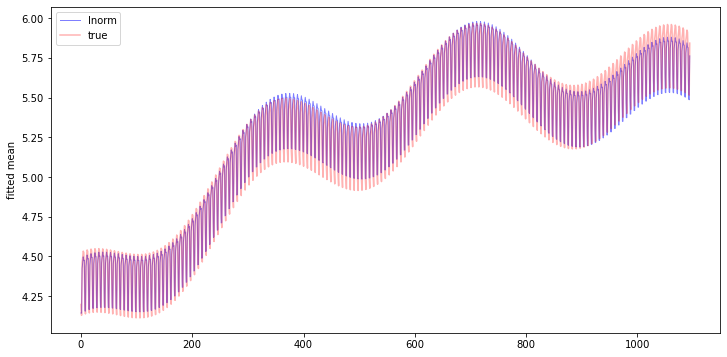

In [15]:
fittedmean(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

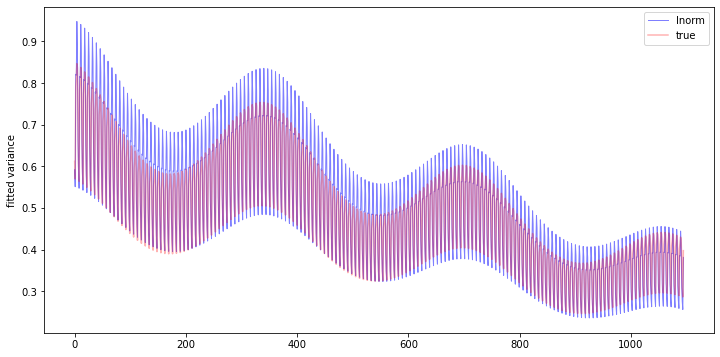

In [16]:
fittedvar(mod_res).plot(alpha = 0.5, color = "blue", linewidth = 1, label = "lnorm")
plt.plot(data.sigma, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted variance")
plt.show()

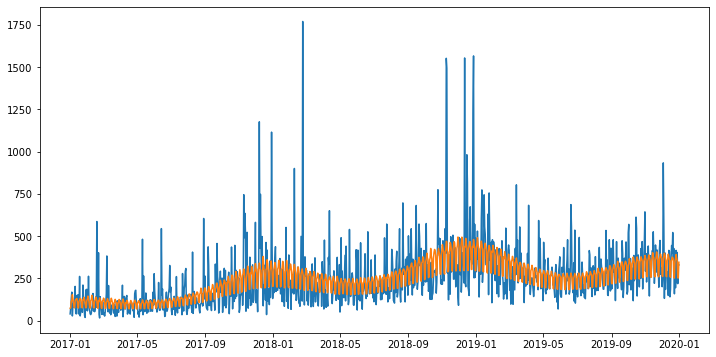

In [17]:
Y_hat = mod_res.predict(n=1000)
plt.plot(data.days, data.y)
plt.plot(data.days, Y_hat)
plt.show()

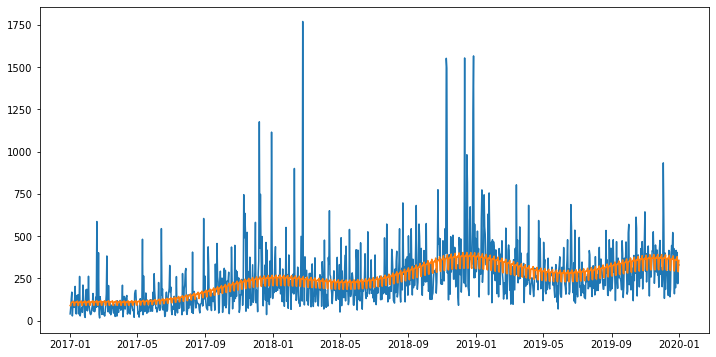

In [18]:
plt.plot(data.days, data.y)
plt.plot(data.days, gpois_res.predict())
plt.show()

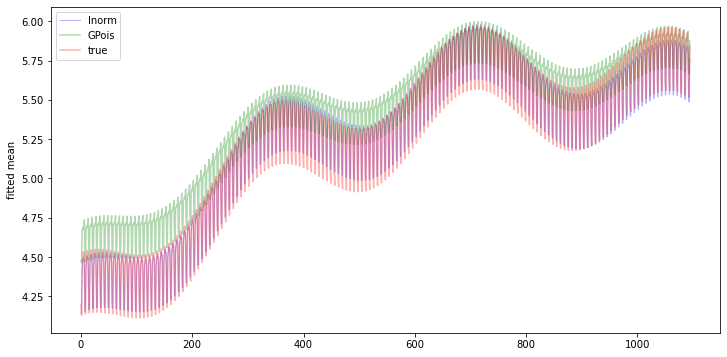

In [19]:
fittedmean(mod_res).plot(alpha = 0.3, color = "blue", linewidth = 1, label = "lnorm")
gpois_res.fittedvalues.plot(alpha = 0.3, color = "green", label = "GPois")
plt.plot(data.mu, alpha = 0.3, color = "red", label = "true")
plt.legend()
plt.ylabel("fitted mean")
plt.show()

In [20]:
# Negative Hessian is PD at optimal values
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, -1., -0.2, -0.03, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.16, -0.05])
starting_vals = np.array([ 5., 0.4, -0.17, 0.33, 0.36, 0.4, 0.39, 0.26, 0.07, 0.2, -0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
np.linalg.eigvals(-mod.hessian(starting_vals))

array([1239.5933922 , 1167.40766673, 1121.97496135,  995.2334662 ,
        650.32410533,  536.79115709,  482.55188468,  356.94623934,
        281.94812872,    6.09171065,   19.79918595,  247.56244619,
         52.49999962,   66.48059834,   91.44124581,   98.83522349,
        116.05822754,  144.40329776,  163.78290386,  153.83744194,
        160.18463146,  156.82738251])

In [21]:
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     bs = mod_res.bootstrap(nrep=1, method="ncg", store = 0, disp = 0) # we can bootstrap SE

In [22]:
# bs[0] #mean estimates

## Simulation 

In [23]:
# What else should we test?
N = 50
penalty = 1e-4
sim_params = list()
sim_mse = list()

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        sim_params.append(["pois"] + pois_res.params[:11].tolist())
        
        gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
        gpois_res = gpois_mdl.fit(disp=0)
        sim_params.append(["gpois"]+ gpois_res.params[:11].tolist())
        
        NB1_mdl = sm.NegativeBinomialP(data.y, data.x_df,p=1)
        NB1_res = NB1_mdl.fit(disp=0)
        sim_params.append(["NB1"]+ NB1_res.params[:11].tolist())
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        sim_params.append(["lnorm"] + mod_res.params[:11].tolist()) # Just the model coeffecients

        data = generate_data() #new data
        Xnew = data.x_df
        # out of sample prediction MSE
        sim_mse.append([mse(mod_res.predict(exog=Xnew), data.y), mse(pois_res.predict(exog=Xnew), data.y), 
                        mse(gpois_res.predict(exog=Xnew), data.y), mse(NB1_res.predict(exog=Xnew), data.y)])


In [24]:
sim_params = pd.DataFrame(sim_params, columns=["model"] + data.x_df.columns.to_list())

In [25]:
sim_params.groupby(by = "model").mean().T

model,NB1,gpois,lnorm,pois
intercept,5.173468,5.216200,4.996740,5.075357
days_since_start,0.344886,0.353197,0.400557,0.348316
days_since_start_squared,-0.137678,-0.127602,-0.167007,-0.167141
day_of_week_1,0.288220,0.239014,0.327279,0.388984
day_of_week_2,0.324618,0.266727,0.362964,0.440830
day_of_week_3,0.352233,0.290459,0.400669,0.476731
day_of_week_4,0.338271,0.277092,0.385377,0.460864
day_of_week_5,0.226402,0.193525,0.262373,0.298255
day_of_week_6,0.058039,0.050535,0.066572,0.076265
seasonality_cos,0.174570,0.143129,0.196389,0.234183


In [26]:
#MSE
pd.DataFrame(sim_mse, columns=["lnorm", "pois", "gpois", "NB1"]).describe()

,lnorm,pois,gpois,NB1
count,50.000000,50.000000,50.000000,50.000000
mean,20620.784413,20628.848475,21241.780757,20878.180017
std,4075.110037,4074.447735,4222.914367,4168.442100
min,16312.568843,16225.973728,16660.323560,16429.592969
25%,18587.258967,18567.677040,18854.918374,18536.443949
50%,19713.318002,19755.017424,20370.204062,19935.667084
75%,22274.089827,22203.723215,22885.628002,22548.276536
max,43118.650429,43168.054888,43888.767384,43452.959778


In [27]:
N = 50
sim_solver_times = list()
sim_solver_fcalls = list()
penalty = 1e-4

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for i in range(N):
        data = generate_data()
        fcalls = []
        
        # Seed with poisson parameters
        pois_mdl = sm.Poisson(data.y, data.x_df)
        pois_res = pois_mdl.fit(disp=0)
        start_params = np.zeros(22)
        start_params[:11] = pois_res.params
        
        mod = MyLatentNormal(data.y, data.x_df, extra_params_names=names_alpha)
        
        start = timer()
        mod_res = mod.fit(method = "ncg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        ncg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "cg", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        cg = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "bfgs", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        bfgs = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        start = timer()
        mod_res = mod.fit(method = "powell", start_params = start_params, maxiter=100, penalty=penalty, disp=0)
        end = timer()
        powell = end-start
        fcalls.append(mod_res.mle_retvals["fcalls"])
        
        sim_solver_times.append([ncg, cg, bfgs, powell])
        sim_solver_fcalls.append(fcalls)

In [28]:
pd.DataFrame(sim_solver_times, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,0.203960,0.398326,0.094018,0.461735
std,0.018645,0.043694,0.002229,0.036807
min,0.175157,0.277787,0.088227,0.363537
25%,0.191377,0.371881,0.092792,0.444235
50%,0.205257,0.399010,0.094238,0.449814
75%,0.209858,0.430596,0.095712,0.453424
max,0.305707,0.506738,0.098959,0.545150


In [29]:
pd.DataFrame(sim_solver_fcalls, columns=["ncg", "cg", "bfgs", "powell"]).describe()

,ncg,cg,bfgs,powell
count,50.000000,50.000000,50.000000,50.000000
mean,16.620000,129.240000,26.680000,1186.060000
std,6.382022,14.619752,0.712569,98.402632
min,13.000000,89.000000,25.000000,912.000000
25%,14.000000,119.250000,26.000000,1148.000000
50%,15.500000,129.000000,27.000000,1150.000000
75%,17.000000,140.000000,27.000000,1152.000000
max,56.000000,164.000000,28.000000,1390.000000
